# Movie Recommendation System with Collaborative Filtering using Nearest Neighbors By-


In [58]:
# Libraries for Recommendation System
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import difflib

# Libraries for Recommendation System
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/movielens-20m-dataset/rating.csv
/kaggle/input/movielens-20m-dataset/link.csv
/kaggle/input/movielens-20m-dataset/genome_tags.csv
/kaggle/input/movielens-20m-dataset/genome_scores.csv
/kaggle/input/movielens-20m-dataset/tag.csv
/kaggle/input/movielens-20m-dataset/movie.csv


# Let's describe dataset:
In this dataset has 6 csv files. I used to movie.csv and rating.csv. We let analyze this csv files.

rating.csv that contains ratings of movies by users:

* userId
* movieId
* rating
* timestamp

movie.csv that contains movie information:

* movieId
* title
* genres

In [59]:
data_movie = pd.read_csv("/kaggle/input/movielens-20m-dataset/movie.csv")
data_rating = pd.read_csv("/kaggle/input/movielens-20m-dataset/rating.csv")

In [60]:
movie = data_movie.loc[:,{"movieId","title"}]
rating = data_rating.loc[:,{"userId","movieId","rating"}]

In [61]:
unique_user = data_rating.userId.nunique(dropna = True)
unique_movie = data_rating.movieId.nunique(dropna = True)
print("number of unique user:")
print(unique_user)
print("number of unique movies:")
print(unique_movie)

number of unique user:
138493
number of unique movies:
26744


In [62]:
# for creating item user matrix  .. we need to check how many ratings we have here or how many are absent .
total_ratings = unique_user*unique_movie
rating_present = data_rating.shape[0]

ratings_not_provided = total_ratings - rating_present 

print("ratings not provided means some user have not watched some movies and its given by")
print(ratings_not_provided)
print("sparsity of user-item matrix is :")
print(ratings_not_provided / total_ratings)

ratings not provided means some user have not watched some movies and its given by
3683856529
sparsity of user-item matrix is :
0.9946001521864456


We are combining two dataframe (movie and rating) and are creating movie vs user matrix.

In [63]:
# 1)plot ratings count which gives information about which rating(on scale of 0 t0 5) is more frequent

rating_cnt = pd.DataFrame(data_rating.groupby('rating').size(),columns=['count'])
rating_cnt
# this rating cnt doesnt contain count of rating 0
# append rating_cnt

rating_cnt = rating_cnt.append(pd.DataFrame({'count':ratings_not_provided},index = [0])).sort_index()
rating_cnt

#since the count of rating 0 is too large in comparison to others rating ...use lag value
rating_cnt['log_count'] = np.log(rating_cnt['count'])
rating_cnt


,count,log_count
0.0,3683856529,22.027226
0.5,239125,12.384742
1.0,680732,13.430924
1.5,279252,12.539870
2.0,1430997,14.173882
2.5,883398,13.691531
3.0,4291193,15.272075
3.5,2200156,14.604039
4.0,5561926,15.531455
4.5,1534824,14.243926


frequency of rating like 3 and 4 are more in compare to other ratings


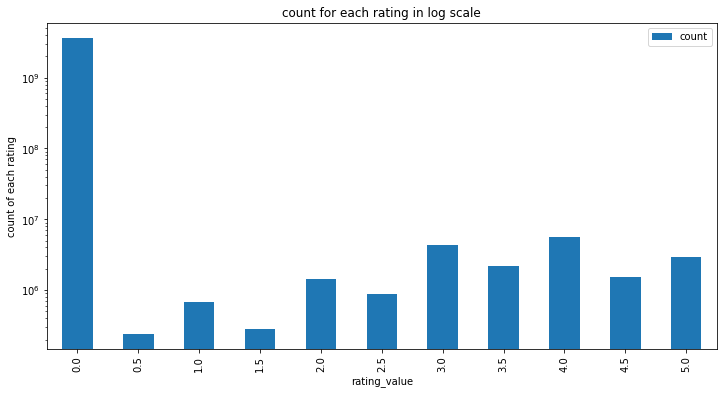

In [64]:
# plot a bar plot to visualise the ratings
rating_cnt_for_vis = rating_cnt
ax = rating_cnt_for_vis.reset_index().rename(columns = {'index':'rating_value'}).plot(
    x='rating_value',
    y='count',
    logy = True,
    kind='bar',
    title='count for each rating in log scale',
    figsize=(12,6)
)
ax.set_xlabel('rating_value')
ax.set_ylabel('count of each rating')
print("frequency of rating like 3 and 4 are more in compare to other ratings")

In [65]:
movie_freq = pd.DataFrame(data_rating.groupby('movieId').size(),columns=['count'])
movie_freq.head()

,count
movieId,
1,49695
2,22243
3,12735
4,2756
5,12161


Text(0, 0.5, 'rating freq of movies')

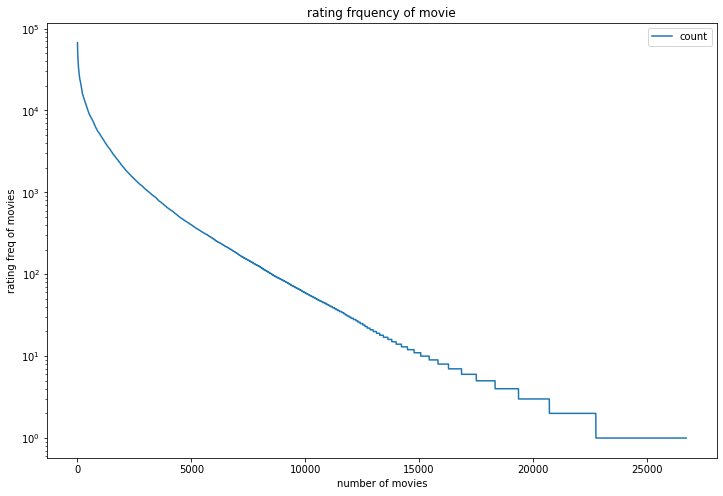

In [66]:
# plot movie rating freq
movie_freq_copy = movie_freq.sort_values(by='count',ascending=False)
movie_freq_copy=movie_freq_copy.reset_index(drop=True)

ax1  = movie_freq_copy.plot(
    title='rating frquency of movie',
    logy=True,
    figsize=(12,8)
)
ax1.set_xlabel('number of movies')
ax1.set_ylabel('rating freq of movies')

In [67]:
# we can see that most of the movies are rated very rarely ..
# so we can remove those movies which are rated less than 50 times.

threshold_rating_freq = 10

# first take out the movie id  for which movie is rated more than threshold value than keep only this movies in our original ratings dataframe
# movie_freq.query('count>= @threshold_rating_freq').shape = (13360,1)
# our original movie_freq has shape of (9724 ,1) and now its reduce to (2269,1)
# so now lets reduce the size of ratings dataframe

popular_movies_id = list(set(movie_freq.query('count>=@threshold_rating_freq').index))

# ratings df after dropping non popular movies
ratings_with_popular_movies = data_rating[data_rating.movieId.isin(popular_movies_id)]

print('shape of ratings:')
print(data_rating.shape)

print('shape of ratings_with_popular_movies:')
print(ratings_with_popular_movies.shape)

print("no of movies which are rated more than 50 times:")
print(len(popular_movies_id))


print("no of unique movies present in dataset:")
print(unique_movie)

shape of ratings:
(20000263, 4)
shape of ratings_with_popular_movies:
(19964833, 4)
no of movies which are rated more than 50 times:
15451
no of unique movies present in dataset:
26744


In [68]:
user_cnt = pd.DataFrame(data_rating.groupby('userId').size(),columns=['count'])
user_cnt_copy = user_cnt
user_cnt.head()

,count
userId,
1,175
2,61
3,187
4,28
5,66


Text(0, 0.5, 'rating frequency')

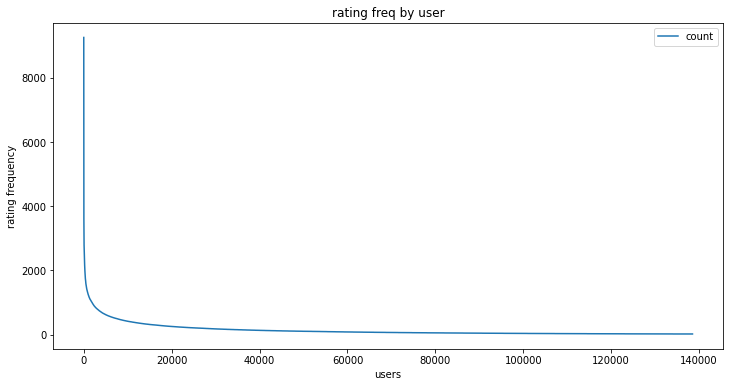

In [69]:
# plot rating freq
ax  = user_cnt_copy.sort_values('count',ascending=False).reset_index(drop=True).plot(
      title='rating freq by user',
      figsize=(12,6),
      
)
ax.set_xlabel("users")
ax.set_ylabel("rating frequency")

In [70]:
# you cans see tha rating frequency vs users characterstics is tail - like structure which is similar to previous plot.
# generally there are just few user who are interseted in giving rating to movies
# lets find the user who gives rating more than 30 times
threshold_val = 30
active_user = list(set(user_cnt.query('count>=@threshold_val').index))

#upadte your ratings_with_popular_movies
ratings_with_popular_movies_with_active_user = ratings_with_popular_movies[ratings_with_popular_movies.userId.isin(active_user)]

print('shape of ratings_with_popular_movies:')
print(ratings_with_popular_movies.shape)

print('shape of ratings_with_popular_movies_with_active_user:')
print(ratings_with_popular_movies_with_active_user.shape)

print("unique_user:")
print(unique_user)

print("active_user")
print(len(active_user))

print("unique_movies")
print(unique_movie)

print("popular_movies")
print(len(popular_movies_id))

shape of ratings_with_popular_movies:
(19964833, 4)
shape of ratings_with_popular_movies_with_active_user:
(19347550, 4)
unique_user:
138493
active_user
112549
unique_movies
26744
popular_movies
15451


In [71]:
data = pd.merge(movie,rating)
data = data.iloc[:1000000,:]
user_movie_table = data.pivot_table(index = ["title"],columns = ["userId"],values = "rating").fillna(0)
user_movie_table.head(10)

userId,1,2,3,4,5,6,7,8,10,11,...,138484,138485,138486,138487,138488,138489,138490,138491,138492,138493
title,,,,,,,,,,,,,,,,,,,,,
Ace Ventura: When Nature Calls (1995),0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,3.5,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
Across the Sea of Time (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Amazing Panda Adventure, The (1995)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"American President, The (1995)",0.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0,4.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Angela (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Angels and Insects (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
Anne Frank Remembered (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Antonia's Line (Antonia) (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
Assassins (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
# We choose random movie.
query_index = np.random.choice(user_movie_table.shape[0])
print("Choosen Movie is: ",user_movie_table.index[query_index])

Choosen Movie is:  Last Summer in the Hamptons (1995)


In [73]:
user_movie_table_matrix = csr_matrix(user_movie_table.values)
print(user_movie_table_matrix)

  (0, 3)	3.0
  (0, 7)	1.0
  (0, 9)	3.5
  (0, 11)	3.0
  (0, 17)	2.5
  (0, 23)	3.0
  (0, 25)	3.0
  (0, 28)	3.0
  (0, 43)	3.0
  (0, 44)	3.0
  (0, 59)	3.0
  (0, 60)	4.0
  (0, 62)	3.5
  (0, 67)	2.0
  (0, 75)	1.0
  (0, 76)	2.0
  (0, 79)	2.0
  (0, 80)	4.0
  (0, 88)	2.0
  (0, 102)	2.5
  (0, 106)	3.0
  (0, 115)	3.0
  (0, 116)	3.0
  (0, 120)	0.5
  (0, 124)	2.0
  :	:
  (145, 120155)	2.5
  (145, 120210)	3.0
  (145, 120247)	3.5
  (145, 120268)	4.0
  (145, 120570)	3.0
  (145, 120680)	2.0
  (145, 120709)	3.0
  (145, 120799)	3.0
  (145, 121089)	1.0
  (145, 121094)	3.0
  (145, 121196)	3.0
  (145, 121378)	4.0
  (145, 121458)	5.0
  (145, 121738)	3.5
  (145, 121905)	4.5
  (145, 121977)	4.0
  (145, 122083)	3.0
  (145, 122099)	3.0
  (145, 122151)	3.5
  (145, 122186)	2.0
  (145, 122325)	5.0
  (145, 122456)	3.5
  (145, 122648)	4.0
  (145, 122896)	2.0
  (145, 123150)	5.0


In [74]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(user_movie_table_matrix)
distances, indices = model_knn.kneighbors(user_movie_table.iloc[query_index,:].values.reshape(1,-1), n_neighbors = 7)
indices

array([[83, 66, 80,  5, 28, 87, 56]])

In this below section, you can see recommendations for Up Close and Personal movie.

In [75]:
movie = []
distance = []

for i in range(0, len(distances.flatten())):
    if i != 0:
        movie.append(user_movie_table.index[indices.flatten()[i]])
        distance.append(distances.flatten()[i])    

m=pd.Series(movie,name='movie')
d=pd.Series(distance,name='distance')
recommend = pd.concat([m,d], axis=1)
recommend = recommend.sort_values('distance',ascending=False)

print('Recommendations for {0}:\n'.format(user_movie_table.index[query_index]))
for i in range(0,recommend.shape[0]):
    print('{0}: {1}, with distance of {2}'.format(i, recommend["movie"].iloc[i], recommend["distance"].iloc[i]))

Recommendations for Last Summer in the Hamptons (1995):

0: From the Journals of Jean Seberg (1995), with distance of 0.9162227289865745
1: Margaret's Museum (1995), with distance of 0.9162011972167224
2: Carrington (1995), with distance of 0.9159935776642906
3: Angels and Insects (1995), with distance of 0.9116588564071717
4: Kicking and Screaming (1995), with distance of 0.9071019112160017
5: Headless Body in Topless Bar (1995), with distance of 0.9069978242919932
